### 1. Import required modules

In [86]:
import geopandas as gpd
import pandas as pd
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

### 2. Get global coastline dataset as GeoDataFrame

In [81]:
coastlines = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

### 3. Get global earthquake catalogue and convert epicentres to GeoDataFrame

In [104]:
min_eq_magnitude = 5.7
start_year = 1970

client_str = "USGS"  # Set FDSN service for retreiving events
c = Client(client_str)
cat = c.get_events(minmagnitude=min_eq_magnitude, starttime=UTCDateTime(start_year, 1, 1))

# Convert cat to dict
cat_dict = {}
cat_dict["Longitude"] = []
cat_dict["Latitude"] = []
for evt in cat:
    cat_dict["Latitude"].append(evt.preferred_origin().latitude)
    cat_dict["Longitude"].append(evt.preferred_origin().longitude)
    
# Convert cat-dict to DataFrame then to GeoDataFrame
df = pd.DataFrame.from_dict(cat_dict)
quakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

### 4. Convert coastlines to single object, then find onshore and offshore quakes

In [107]:
c2 = coastlines.geometry.unary_union
offshore_quakes = quakes[~quakes.geometry.within(c2)]
onshore_quakes = quakes[quakes.geometry.within(c2)]

### 5. Now plot!

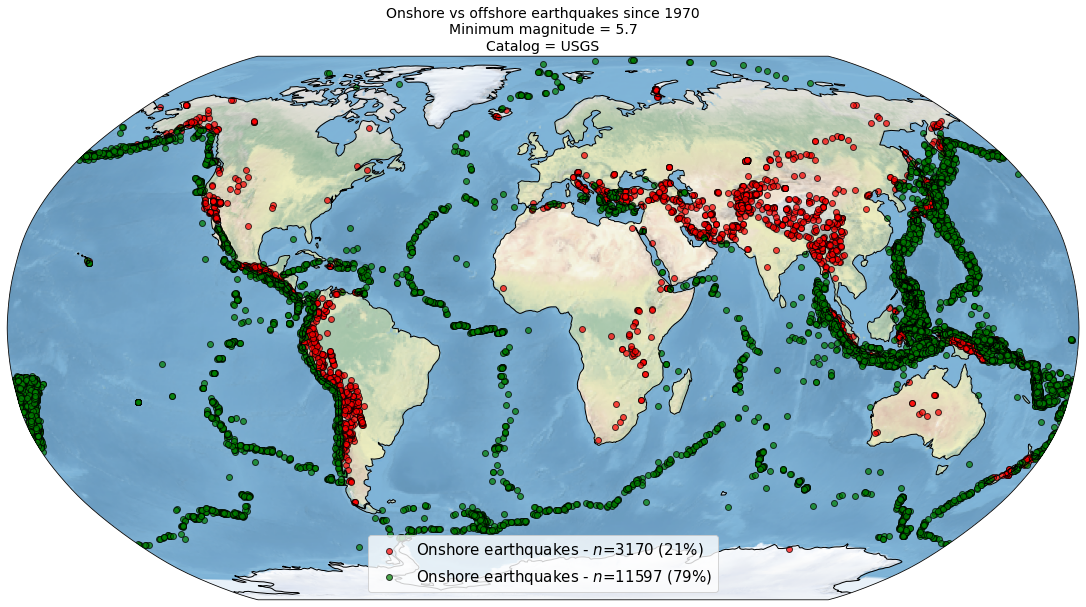

In [108]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.stock_img()
ax.coastlines()

ax.scatter(onshore_quakes.Longitude, onshore_quakes.Latitude, transform=ccrs.PlateCarree(),
           fc="red", ec="k", alpha=0.7,
           label="Onshore earthquakes - $n$={} ({:2.0f}%)".format(
               len(onshore_quakes), 100*len(onshore_quakes)/len(quakes)))
ax.scatter(offshore_quakes.Longitude, offshore_quakes.Latitude, transform=ccrs.PlateCarree(),
           fc="green", ec="k", alpha=0.7,
           label="Onshore earthquakes - $n$={} ({:2.0f}%)".format(
               len(offshore_quakes), 100*len(offshore_quakes)/len(quakes)))
ax.legend(fontsize=15)
plt.title(
    "Onshore vs offshore earthquakes since {}\nMinimum magnitude = {}\nCatalog = {}".format(
        start_year, min_eq_magnitude, client_str), fontsize=14)
plt.savefig("onshore_offshore_quakes.png", transparent=False, dpi=300)